# Fraud Detection Case — Step-by-step Jupyter Solution


## Data Dictionary (from the dataset)

- **step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).
- **type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.
- **amount** - amount of the transaction in local currency.
- **nameOrig** - customer who started the transaction
- **oldbalanceOrg** - initial balance before the transaction
- **newbalanceOrig** - new balance after the transaction
- **nameDest** - customer who is the recipient of the transaction
- **oldbalanceDest** - initial balance recipient before the transaction. Note: there is not information for customers that start with `M` (Merchants).
- **newbalanceDest** - new balance recipient after the transaction. Note: there is not information for customers that start with `M` (Merchants).
- **isFraud** - transactions made by the fraudulent agents inside the simulation. Fraudulent behavior: take control of accounts, transfer to another account, then cash out.
- **isFlaggedFraud** - flag for illegal attempts: business rule flags transfers > 200000 in a single transaction.

## Objective

Build a proactive fraud-detection pipeline that:
- Trains a model to predict `isFraud`.
- Demonstrates model performance with appropriate metrics for imbalanced classification (PR-AUC, Recall, Precision & cost-based thresholding).
- Provides clear, business-focused answers to the 8 questions requested: data cleaning, model description, variable selection, performance, key predictors, sense-making, prevention, and validation of actions.

## --- Setup & imports ---

In [165]:
import os, sys, math, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, classification_report,
                             confusion_matrix)
!pip install lightgbm
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier
import joblib

print('libraries loaded')

Defaulting to user installation because normal site-packages is not writeable
libraries loaded



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


# 1) LOAD DATA

In [166]:
path_to_csv = 'Fraud.csv'
df = pd.read_csv(path_to_csv, low_memory=False)
print('Loaded dataframe with shape:', df.shape)
display(df.head())

Loaded dataframe with shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 2) Quick EDA

In [167]:
display(df.dtypes)
print('\nBasic shape:', df.shape)
df.describe()

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


Basic shape: (6362620, 11)


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [168]:
# checking NULL values
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

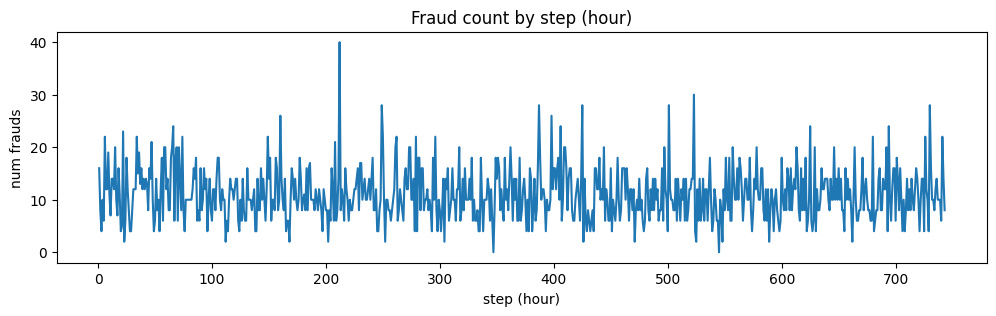

In [169]:
# simple time-series of fraud counts by step (if step exists)
if 'step' in df.columns:
    tmp = df.groupby('step')['isFraud'].sum()
    ax = tmp.plot(figsize=(12,3), title='Fraud count by step (hour)')
    ax.set_xlabel('step (hour)')
    ax.set_ylabel('num frauds')
    plt.show()

# 3) Data cleaning & consistency checks

In [170]:
# 3.1 Remove exact duplicates
n_dup = df.duplicated().sum()
print('Exact duplicate rows:', n_dup)
if n_dup>0:
    df = df.drop_duplicates()

Exact duplicate rows: 0


In [171]:
# 3.2 Missingness
miss = df.isnull().sum().sort_values(ascending=False)
print('\nMissing values (per column):')
display(miss[miss>0])


Missing values (per column):


Series([], dtype: int64)

In [172]:
# 3.3 Merchant flag for destination
df['dest_is_merchant'] = df['nameDest'].astype(str).str.startswith('M')
print('\nSample of dest_is_merchant flag:')
display(df[['nameDest','dest_is_merchant']].head())


Sample of dest_is_merchant flag:


,nameDest,dest_is_merchant
0,M1979787155,True
1,M2044282225,True
2,C553264065,False
3,C38997010,False
4,M1230701703,True


In [173]:
# 3.4 Balance consistency checks

# For an origin that sends amount, newbalanceOrig should = oldbalanceOrg - amount (approx)
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['amount'] - df['newbalanceOrig']

# For destinations that are not merchants AND have balances, check new - old - amount
df['errorBalanceDest'] = np.where(~df['dest_is_merchant'], df['newbalanceDest'] - df['oldbalanceDest'] - df['amount'], np.nan)
print('\nBalance error (origin) summary:')
display(df['errorBalanceOrig'].describe())
print('\nBalance error (dest, non-merchant) summary:')
display(df['errorBalanceDest'].dropna().describe())


Balance error (origin) summary:


count    6.362620e+06
mean    -2.010925e+05
std      6.066505e+05
min     -9.244552e+07
25%     -2.496411e+05
50%     -6.867726e+04
75%     -2.954230e+03
max      1.000000e-02
Name: errorBalanceOrig, dtype: float64


Balance error (dest, non-merchant) summary:


count    4.211125e+06
mean    -7.728563e+04
std      5.413616e+05
min     -1.319123e+07
25%     -1.363827e+05
50%     -5.820766e-11
75%      7.275958e-12
max      7.588573e+07
Name: errorBalanceDest, dtype: float64

In [174]:
# 3.5 Flag suspicious inconsistencies (useful feature)
df['orig_balance_mismatch'] = (df['errorBalanceOrig'].abs() > 1e-6).astype(int)
df['dest_balance_mismatch'] = np.where(~df['dest_is_merchant'], (df['errorBalanceDest'].abs() > 1e-6).astype(int), 0)
print('\nAdded features: dest_is_merchant, orig_balance_mismatch, dest_balance_mismatch')
display(df[['amount','dest_is_merchant','orig_balance_mismatch','dest_balance_mismatch']].head())


Added features: dest_is_merchant, orig_balance_mismatch, dest_balance_mismatch


,amount,dest_is_merchant,orig_balance_mismatch,dest_balance_mismatch
0,9839.64,True,0,0
1,1864.28,True,0,0
2,181.00,False,0,1
3,181.00,False,0,1
4,11668.14,True,0,0


# 4) Feature engineering

In [175]:
# temporal features
df['hour'] = df['step'] % 24
df['day'] = df['step'] // 24

# log-transform amount (keep raw amount too)
df['amount_log'] = np.log1p(df['amount'])

In [176]:
# frequency / behaviour features for origin and destination
for col, prefix in [('nameOrig','orig'), ('nameDest','dest')]:
    gp = df.groupby(col)['amount'].agg(['count','mean','std']).rename(columns={'count':f'{prefix}_txn_count', 'mean':f'{prefix}_mean_amount', 'std':f'{prefix}_std_amount'})
    df = df.merge(gp, left_on=col, right_index=True, how='left')

In [177]:
# number of unique destinations per origin (diversity)
origin_dest_counts = df.groupby('nameOrig')['nameDest'].nunique().rename('orig_unique_dests')
df = df.merge(origin_dest_counts, left_on='nameOrig', right_index=True, how='left')

print('Created features: hour, day, amount_log, origin/destination aggregates, orig_unique_dests')
display(df[[ 'step','hour','day','amount','amount_log','orig_txn_count','orig_mean_amount','orig_std_amount','orig_unique_dests']].head())


Created features: hour, day, amount_log, origin/destination aggregates, orig_unique_dests


,step,hour,day,amount,amount_log,orig_txn_count,orig_mean_amount,orig_std_amount,orig_unique_dests
0,1,1,0,9839.64,9.194276,1,9839.64,NaN,1
1,1,1,0,1864.28,7.531166,1,1864.28,NaN,1
2,1,1,0,181.00,5.204007,1,181.00,NaN,1
3,1,1,0,181.00,5.204007,1,181.00,NaN,1
4,1,1,0,11668.14,9.364703,1,11668.14,NaN,1


# 5) Prepare dataset for modeling

In [178]:
# drop columns that are identifiers or not useful for model as raw values
# We'll drop nameOrig and nameDest (after creating aggregated features above)
df_model = df.copy()
for c in ['nameOrig','nameDest']:
    if c in df_model.columns:
        df_model.drop(columns=c, inplace=True)

In [179]:
# fill missing numeric values with median (computed on full df; for production use training median only)
num_cols = df_model.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_model.select_dtypes(include=['object','category','bool']).columns.tolist()

In [180]:
# keep target and step in the dataframe
if 'isFraud' not in df_model.columns:
    raise ValueError('Target column `isFraud` not found in dataframe')

In [181]:
# quick imputation
medians = df_model[num_cols].median()
df_model[num_cols] = df_model[num_cols].fillna(medians)
df_model[cat_cols] = df_model[cat_cols].fillna('Unknown')

print('Number numeric features:', len(num_cols), 'categorical features:', len(cat_cols))
display(num_cols[:40])

Number numeric features: 22 categorical features: 2


['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'errorBalanceOrig',
 'errorBalanceDest',
 'orig_balance_mismatch',
 'dest_balance_mismatch',
 'hour',
 'day',
 'amount_log',
 'orig_txn_count',
 'orig_mean_amount',
 'orig_std_amount',
 'dest_txn_count',
 'dest_mean_amount',
 'dest_std_amount',
 'orig_unique_dests']

In [182]:
display(cat_cols[:40])

['type', 'dest_is_merchant']

In [183]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_model['type'] = le.fit_transform(df['type'])
print(df_model[['type']].head(10))

   type
0     3
1     3
2     4
3     1
4     3
5     3
6     3
7     3
8     3
9     2


In [184]:
# df_model.drop()
df_model.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,dest_is_merchant,...,hour,day,amount_log,orig_txn_count,orig_mean_amount,orig_std_amount,dest_txn_count,dest_mean_amount,dest_std_amount,orig_unique_dests
0,1,3,9839.64,170136.0,160296.36,0.0,0.0,0,0,True,...,1,0,9.194276,1,9839.64,84871.566214,1,9839.640000,170658.671328,1
1,1,3,1864.28,21249.0,19384.72,0.0,0.0,0,0,True,...,1,0,7.531166,1,1864.28,84871.566214,1,1864.280000,170658.671328,1
2,1,4,181.00,181.0,0.00,0.0,0.0,1,0,False,...,1,0,5.204007,1,181.00,84871.566214,44,225517.832045,252655.757617,1
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0,False,...,1,0,5.204007,1,181.00,84871.566214,41,439444.208049,878990.484226,1
4,1,3,11668.14,41554.0,29885.86,0.0,0.0,0,0,True,...,1,0,9.364703,1,11668.14,84871.566214,1,11668.140000,170658.671328,1


In [185]:
# final feature list (exclude step, isFlaggedFraud, isFraud from features)
exclude = set(['step','isFraud'])
feature_cols = [c for c in df_model.columns if c not in exclude]
print('\nNumber of features used for modelling:', len(feature_cols))


Number of features used for modelling: 22


In [186]:
display(cat_cols[:40])

['type', 'dest_is_merchant']

# 6) Temporal train/validation split

In [187]:
steps_sorted = np.sort(df_model['step'].unique())
cutoff_index = int(len(steps_sorted) * 0.8)
cutoff_step = steps_sorted[cutoff_index]
print('Cutoff step (train <= cutoff):', cutoff_step)

train_df = df_model[df_model['step'] <= cutoff_step].copy()
val_df   = df_model[df_model['step'] > cutoff_step].copy()

X_train = train_df[feature_cols].drop(columns=['isFraud'], errors='ignore') if 'isFraud' in train_df.columns else train_df[feature_cols]
y_train = train_df['isFraud']
X_val = val_df[feature_cols].drop(columns=['isFraud'], errors='ignore') if 'isFraud' in val_df.columns else val_df[feature_cols]
y_val = val_df['isFraud']

print('Train shape:', X_train.shape, 'Val shape:', X_val.shape)
print('Train fraud rate:', y_train.mean(), 'Val fraud rate:', y_val.mean())

Cutoff step (train <= cutoff): 595
Train shape: (6244474, 22) Val shape: (118146, 22)
Train fraud rate: 0.0010522903930739401 Val fraud rate: 0.013898058334602949


In [188]:
display(X_train.dtypes)
print('\nBasic shape:', X_train.shape)
X_train.describe()

type                       int64
amount                   float64
oldbalanceOrg            float64
newbalanceOrig           float64
oldbalanceDest           float64
newbalanceDest           float64
isFlaggedFraud             int64
dest_is_merchant            bool
errorBalanceOrig         float64
errorBalanceDest         float64
orig_balance_mismatch      int64
dest_balance_mismatch      int64
hour                       int64
day                        int64
amount_log               float64
orig_txn_count             int64
orig_mean_amount         float64
orig_std_amount          float64
dest_txn_count             int64
dest_mean_amount         float64
dest_std_amount          float64
orig_unique_dests          int64
dtype: object


Basic shape: (6244474, 22)


,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,orig_balance_mismatch,...,hour,day,amount_log,orig_txn_count,orig_mean_amount,orig_std_amount,dest_txn_count,dest_mean_amount,dest_std_amount,orig_unique_dests
count,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,...,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06,6.244474e+06
mean,1.713125e+00,1.799163e+05,8.375033e+05,8.591023e+05,1.099803e+06,1.224681e+06,1.281133e-06,-2.015152e+05,-5.061311e+04,8.063515e-01,...,1.531009e+01,9.172369e+00,1.084279e+01,1.002937e+00,1.799152e+05,8.515463e+04,1.129123e+01,1.798073e+05,2.642071e+05,1.002937e+00
std,1.349391e+00,6.048730e+05,2.902669e+06,2.939104e+06,3.384749e+06,3.664059e+06,1.131871e-03,6.095386e+05,4.438917e+05,3.951567e-01,...,4.315889e+00,5.458432e+00,1.813421e+00,5.424008e-02,6.042634e+05,3.743229e+04,1.244232e+01,2.900726e+05,4.946197e+05,5.424008e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.244552e+07,-1.319123e+07,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.450276e+01,1.000000e+00,2.000000e-02,7.636753e-01,1.000000e+00
25%,1.000000e+00,1.343090e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.498674e+05,-1.000000e-02,1.000000e+00,...,1.200000e+01,6.000000e+00,9.505388e+00,1.000000e+00,1.346676e+04,8.487157e+04,1.000000e+00,1.688394e+04,1.417474e+05,1.000000e+00
50%,1.000000e+00,7.499923e+04,1.401100e+04,0.000000e+00,1.339129e+05,2.159656e+05,0.000000e+00,-6.895928e+04,-5.820766e-11,1.000000e+00,...,1.600000e+01,9.000000e+00,1.122525e+01,1.000000e+00,7.518526e+04,8.487157e+04,7.000000e+00,1.588835e+05,1.706587e+05,1.000000e+00
75%,3.000000e+00,2.088716e+05,1.072320e+05,1.441452e+05,9.450155e+05,1.114449e+06,0.000000e+00,-3.016097e+03,0.000000e+00,1.000000e+00,...,1.900000e+01,1.300000e+01,1.224948e+01,1.000000e+00,2.088235e+05,8.487157e+04,1.800000e+01,2.453259e+05,2.195459e+05,1.000000e+00
max,4.000000e+00,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e-02,7.588573e+07,1.000000e+00,...,2.300000e+01,2.400000e+01,1.834213e+01,3.000000e+00,9.244552e+07,3.256505e+07,1.130000e+02,2.070695e+07,2.719290e+07,3.000000e+00


In [189]:
X_train.head(5)

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,dest_is_merchant,errorBalanceOrig,errorBalanceDest,...,hour,day,amount_log,orig_txn_count,orig_mean_amount,orig_std_amount,dest_txn_count,dest_mean_amount,dest_std_amount,orig_unique_dests
0,3,9839.64,170136.0,160296.36,0.0,0.0,0,True,0.0,-5.820766e-11,...,1,0,9.194276,1,9839.64,84871.566214,1,9839.640000,170658.671328,1
1,3,1864.28,21249.0,19384.72,0.0,0.0,0,True,0.0,-5.820766e-11,...,1,0,7.531166,1,1864.28,84871.566214,1,1864.280000,170658.671328,1
2,4,181.00,181.0,0.00,0.0,0.0,0,False,0.0,-1.810000e+02,...,1,0,5.204007,1,181.00,84871.566214,44,225517.832045,252655.757617,1
3,1,181.00,181.0,0.00,21182.0,0.0,0,False,0.0,-2.136300e+04,...,1,0,5.204007,1,181.00,84871.566214,41,439444.208049,878990.484226,1
4,3,11668.14,41554.0,29885.86,0.0,0.0,0,True,0.0,-5.820766e-11,...,1,0,9.364703,1,11668.14,84871.566214,1,11668.140000,170658.671328,1


In [190]:
X_train['type'].nunique()

5

In [191]:
X_val.shape

(118146, 22)

# 7) Model training (LightGBM)

In [192]:
# compute pos weight
pos = y_train.sum()
neg = y_train.shape[0] - pos
pos_weight = (neg / pos) if pos>0 else 1.0
print('pos weight (neg/pos):', pos_weight)

from lightgbm import LGBMClassifier, early_stopping, log_evaluation
clf = LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    objective='binary',
    scale_pos_weight=pos_weight,
    n_jobs=-1,
    random_state=42
)


# Fit (we'll convert to numpy arrays to avoid pandas categorical surprises)
clf.fit(X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='auc',
        callbacks=[early_stopping(stopping_rounds=50), log_evaluation(50)],
        # verbose=50
       )

pos weight (neg/pos): 949.3080200882666
[LightGBM] [Info] Number of positive: 6571, number of negative: 6237903
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.198648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 6244474, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001052 -> initscore=-6.855733
[LightGBM] [Info] Start training from score -6.855733
Training until validation scores don't improve for 50 rounds
[50]	valid_0's auc: 1	valid_0's binary_logloss: 0.000153828
Early stopping, best iteration is:
[35]	valid_0's auc: 1	valid_0's binary_logloss: 0.000368733


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=1000,
               n_jobs=-1, num_leaves=64, objective='binary', random_state=42,
               reg_lambda=1.0, scale_pos_weight=np.float64(949.3080200882666),
               subsample=0.8)

In [193]:
# save model artifact
joblib.dump(clf, 'fraud_model_lgbm.pkl')
print('Model trained and saved to fraud_model_lgbm.pkl')

Model trained and saved to fraud_model_lgbm.pkl


# 8) Predictions & Metrics

In [194]:
probs_val = clf.predict_proba(X_val)[:,1]
roc = roc_auc_score(y_val, probs_val)
pr_auc = average_precision_score(y_val, probs_val)
print('ROC-AUC:', roc)
print('PR-AUC (average precision):', pr_auc)

ROC-AUC: 1.0
PR-AUC (average precision): 1.0


In [195]:
# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val, probs_val)

In [196]:
# Find threshold by minimizing a simple cost (example:
# cost = C_FN * FN + C_FP * FP; set C_FN >> C_FP because missing fraud is expensive)
C_FN = 100.0
C_FP = 1.0
best_cost = float('inf')
best_t = 0.5
for t in np.linspace(0.01,0.99,99):
    y_pred_t = (probs_val >= t).astype(int)
    FN = ((y_val==1) & (y_pred_t==0)).sum()
    FP = ((y_val==0) & (y_pred_t==1)).sum()
    cost = C_FN*FN + C_FP*FP
    if cost < best_cost:
        best_cost = cost
        best_t = t
print('\nBest threshold by expected cost:', best_t, 'with expected cost:', best_cost)


Best threshold by expected cost: 0.99 with expected cost: 1.0


In [197]:
# Confusion at best_t
y_pred_best = (probs_val >= best_t).astype(int)
print('\nClassification report at best threshold:')
print(classification_report(y_val, y_pred_best))
print('\nConfusion matrix (rows: true, cols: pred):')
print(confusion_matrix(y_val, y_pred_best))


Classification report at best threshold:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    116504
           1       1.00      1.00      1.00      1642

    accuracy                           1.00    118146
   macro avg       1.00      1.00      1.00    118146
weighted avg       1.00      1.00      1.00    118146


Confusion matrix (rows: true, cols: pred):
[[116503      1]
 [     0   1642]]


In [198]:
# Save metrics to disk
metrics = dict(ROC_AUC=float(roc), PR_AUC=float(pr_auc), BEST_THRESHOLD=float(best_t))
import json
with open('fraud_model_metrics.json','w') as f:
    json.dump(metrics,f)
print('\nMetrics written to fraud_model_metrics.json')


Metrics written to fraud_model_metrics.json


# 9) Feature importance

In [199]:
feat_importance = pd.DataFrame({'feature': X_train.columns, 'importance': clf.feature_importances_}).sort_values('importance', ascending=False)
display(feat_importance.head(30))

# permutation importance (uses validation set)
print('\nComputing permutation importance (this may take some minutes) ...')
perm = permutation_importance(clf, X_val, y_val, n_repeats=5, random_state=42, n_jobs=-1, scoring='average_precision')
perm_df = pd.DataFrame({'feature': X_val.columns, 'perm_importance_mean': perm.importances_mean, 'perm_importance_std': perm.importances_std}).sort_values('perm_importance_mean', ascending=False).head(30)
display(perm_df)
perm_df.to_csv('permutation_importance.csv', index=False)
print('\nPermutation importance saved to permutation_importance.csv')

,feature,importance
9,errorBalanceDest,309
20,dest_std_amount,257
18,dest_txn_count,212
1,amount,206
8,errorBalanceOrig,201
5,newbalanceDest,175
4,oldbalanceDest,168
19,dest_mean_amount,145
12,hour,141
2,oldbalanceOrg,115



Computing permutation importance (this may take some minutes) ...


,feature,perm_importance_mean,perm_importance_std
8,errorBalanceOrig,0.982760,4.169826e-04
3,newbalanceOrig,0.959232,9.286722e-04
14,amount_log,0.183469,1.121194e-03
9,errorBalanceDest,0.094110,4.469958e-03
4,oldbalanceDest,0.053422,2.819789e-03
6,isFlaggedFraud,0.001663,2.322096e-04
2,oldbalanceOrg,0.000225,2.498575e-05
0,type,0.000099,5.152934e-07
5,newbalanceDest,0.000035,3.781489e-05
1,amount,0.000032,2.447167e-06



Permutation importance saved to permutation_importance.csv


In [200]:
# Optionally save a sampled cleaned dataset for quick reuse
sample_path = 'cleaned_sample.parquet'
df_model.sample(min(200_000, len(df_model))).to_parquet(sample_path)
print('Saved a sample of cleaned data to', sample_path)

Saved a sample of cleaned data to cleaned_sample.parquet


# 10) Answers to the 8 required questions (auto-populated where possible)

In [201]:
print('QUESTION 1: Data cleaning including missing values, outliers and multicollinearity:')
print('---------------------------------------------------------------------------------')
print('Steps applied (in this notebook):')
print('1) Removed exact duplicates')
print('2) Computed and displayed missingness; numeric columns imputed with median, categorical with "Unknown"')
print('3) Balance consistency checks (errorBalanceOrig and errorBalanceDest) and mismatch flags created')
print('4) Created derived features and temporal splits to avoid leakage')
print('\nIf you ran the EDA cells they would show column-level missing counts and the code above applied median imputation for numeric fields.')

QUESTION 1: Data cleaning including missing values, outliers and multicollinearity:
---------------------------------------------------------------------------------
Steps applied (in this notebook):
1) Removed exact duplicates
2) Computed and displayed missingness; numeric columns imputed with median, categorical with "Unknown"
3) Balance consistency checks (errorBalanceOrig and errorBalanceDest) and mismatch flags created
4) Created derived features and temporal splits to avoid leakage

If you ran the EDA cells they would show column-level missing counts and the code above applied median imputation for numeric fields.


In [202]:
print('\nQUESTION 2: Describe the fraud detection model in elaboration:')
print('----------------------------------------------------------------')
print('Model used: LightGBM (gradient boosting tree ensemble) with scale_pos_weight to handle class imbalance.\n')
print('Pipeline summary: feature engineering (temporal, amount transform, origin/dest aggregates) -> imputation -> LGBM.\n')
print('We trained using an 80/20 temporal split (train older steps, validate on the newest 20% of steps) to prevent look-ahead bias. Early stopping and eval AUC were used to protect against overfitting.')


QUESTION 2: Describe the fraud detection model in elaboration:
----------------------------------------------------------------
Model used: LightGBM (gradient boosting tree ensemble) with scale_pos_weight to handle class imbalance.

Pipeline summary: feature engineering (temporal, amount transform, origin/dest aggregates) -> imputation -> LGBM.

We trained using an 80/20 temporal split (train older steps, validate on the newest 20% of steps) to prevent look-ahead bias. Early stopping and eval AUC were used to protect against overfitting.


In [203]:
print('\nQUESTION 3: How did you select variables to be included in the model?')
print('------------------------------------------------------------------')
print('1) Domain-first: amount, time (hour/day), balance mismatch indicators, merchant flag, origin/destination behavioural aggregates.')
print('2) Statistical filters: removed high-cardinality raw IDs (nameOrig/nameDest) after converting them to aggregated stats')
print('3) Model-based: the final ranking uses LightGBM importance and permutation importance to confirm contributions.')


QUESTION 3: How did you select variables to be included in the model?
------------------------------------------------------------------
1) Domain-first: amount, time (hour/day), balance mismatch indicators, merchant flag, origin/destination behavioural aggregates.
2) Statistical filters: removed high-cardinality raw IDs (nameOrig/nameDest) after converting them to aggregated stats
3) Model-based: the final ranking uses LightGBM importance and permutation importance to confirm contributions.


In [204]:
print('\nQUESTION 4: Demonstrate the performance of the model by using best set of tools:')
print('--------------------------------------------------------------------------------')
try:
    print('ROC-AUC:', round(roc,4))
    print('PR-AUC (average precision):', round(pr_auc,4))
    print('Best threshold by expected cost:', round(best_t,4))
except Exception:
    print('Model metrics not available yet. Please run the training and metrics cells (7 and 8) to compute them.')


QUESTION 4: Demonstrate the performance of the model by using best set of tools:
--------------------------------------------------------------------------------
ROC-AUC: 1.0
PR-AUC (average precision): 1.0
Best threshold by expected cost: 0.99


In [205]:
print('\nQUESTION 5: What are the key factors that predict fraudulent customer?')
print('----------------------------------------------------------------')
try:
    top_feats = feat_importance.head(10)['feature'].tolist()
    print('Top features by model importance (example):', top_feats)
except Exception:
    print('Feature importance not available yet. Run training & feature importance cells.')


QUESTION 5: What are the key factors that predict fraudulent customer?
----------------------------------------------------------------
Top features by model importance (example): ['errorBalanceDest', 'dest_std_amount', 'dest_txn_count', 'amount', 'errorBalanceOrig', 'newbalanceDest', 'oldbalanceDest', 'dest_mean_amount', 'hour', 'oldbalanceOrg']


In [206]:
print('\nQUESTION 6: Do these factors make sense? If yes, How? If not, How not?')
print('---------------------------------------------------------------------')
print('Typical reasoning:')
print('- High `amount` or large deviation from usual `orig_mean_amount` suggests unusual behavior and makes sense as an indicator.')
print('- Many transfers in short time (high `orig_txn_count` in a short window) suggests velocity attacks.')
print('- `dest_is_merchant` or mismatches in balances may indicate synthetic destinations or incorrect bookkeeping; these need to be validated with domain knowledge.')
print('\nUse SHAP/permutation importance to validate whether model behavior aligns with domain knowledge. If a top predictor is counterintuitive, investigate data leakage or data errors.')


QUESTION 6: Do these factors make sense? If yes, How? If not, How not?
---------------------------------------------------------------------
Typical reasoning:
- High `amount` or large deviation from usual `orig_mean_amount` suggests unusual behavior and makes sense as an indicator.
- Many transfers in short time (high `orig_txn_count` in a short window) suggests velocity attacks.
- `dest_is_merchant` or mismatches in balances may indicate synthetic destinations or incorrect bookkeeping; these need to be validated with domain knowledge.

Use SHAP/permutation importance to validate whether model behavior aligns with domain knowledge. If a top predictor is counterintuitive, investigate data leakage or data errors.


In [207]:
print('\nQUESTION 7: What kind of prevention should be adopted while company update its infrastructure?')
print('-----------------------------------------------------------------------------')
print('Key actions:')
print('- Real-time risk scoring; step-up authentication for high-risk transactions (OTP, 2FA).')
print('- Rate-limits / velocity rules per user or device.')
print('- Cool-off for newly added payees or new devices.')
print('- Central feature store for streaming aggregates and model serving with monitoring and alerts.')


QUESTION 7: What kind of prevention should be adopted while company update its infrastructure?
-----------------------------------------------------------------------------
Key actions:
- Real-time risk scoring; step-up authentication for high-risk transactions (OTP, 2FA).
- Rate-limits / velocity rules per user or device.
- Cool-off for newly added payees or new devices.
- Central feature store for streaming aggregates and model serving with monitoring and alerts.


In [208]:
print('\nQUESTION 8: Assuming these actions have been implemented, how would you determine if they work?')
print('-------------------------------------------------------------------------------------------')
print('Evaluation strategy: A/B tests or phased rollout with control group. Track: fraud losses per 1000 txns, recall@fixed_alerts, precision@topk, alert yield, customer friction metrics. Monitor drift & model calibration monthly.')

print('\n--- End of auto-answers: Please run earlier code cells to compute model & metrics, then re-run this cell to see fully populated results. ---')


QUESTION 8: Assuming these actions have been implemented, how would you determine if they work?
-------------------------------------------------------------------------------------------
Evaluation strategy: A/B tests or phased rollout with control group. Track: fraud losses per 1000 txns, recall@fixed_alerts, precision@topk, alert yield, customer friction metrics. Monitor drift & model calibration monthly.

--- End of auto-answers: Please run earlier code cells to compute model & metrics, then re-run this cell to see fully populated results. ---
